In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [2]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 88440277.24it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


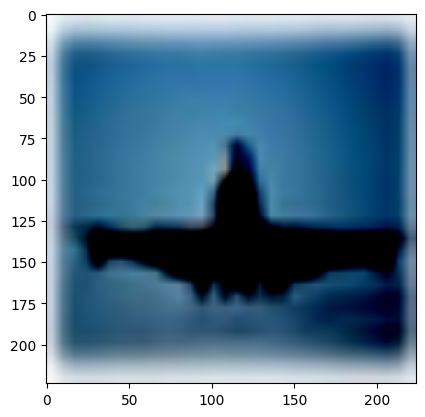

plane


In [4]:
sample_num = 694

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [6]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_red, ch3x3, ch5x5_red, ch5x5, pool):
        super(InceptionModule, self).__init__()

        self.conv1x1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.conv3x3 = nn.Sequential(
            BaseConv2d(in_channels, ch3x3_red, kernel_size=1),
            BaseConv2d(ch3x3_red, ch3x3, kernel_size=3, padding=1)
        )

        self.conv5x5 = nn.Sequential(
            BaseConv2d(in_channels, ch5x5_red, kernel_size=1),
            BaseConv2d(ch5x5_red, ch5x5, kernel_size=5, padding=2)
        )

        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BaseConv2d(in_channels, pool, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)

        return torch.cat([x1, x2, x3, x4], 1)

class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.ReLU = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.ReLU(self.conv(x))

In [7]:
class GoogLeNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(GoogLeNet, self).__init__()

        self.training = True

        self.conv1 = nn.Sequential(
            BaseConv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            BaseConv2d(64, 64, kernel_size=1),
            BaseConv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = AuxModule(512, num_classes)


        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxModule(528, num_classes)

        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training:
            return [x, out1, out2]
        else:
            return x

    def set_train(self):
        self.training = True

    def set_eval(self):
        self.training = False
class AuxModule(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxModule, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.conv1 = BaseConv2d(in_channels, 128, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)



In [8]:
model = GoogLeNet(3,10).cuda()
summary(model, input_size=(3, 224, 224), device='cuda')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
        BaseConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 LocalResponseNorm-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
              ReLU-7           [-1, 64, 56, 56]               0
        BaseConv2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         110,784
             ReLU-10          [-1, 192, 56, 56]               0
       BaseConv2d-11          [-1, 192, 56, 56]               0
LocalResponseNorm-12          [-1, 192, 56, 56]               0
        MaxPool2d-13          [-1, 192, 28, 28]               0
           Conv2d-14           [-1, 64,